<div align="center" style="color:white; background-color:#0f111a; padding: 30px; border-radius: 10px;">
  <h1 style="font-size: 2.5em;">🌌 Rwanda Data Science Hackathon for Development</h1>
  <h2>🛰️ CubeSat Image Classification Challenge</h2>
  <h3>👥 Team 3 – Regional Hackathon</h3>
    <h4>XGBoost-based ML Pipeline</h4>
</div>
  

---

## Classification Using Machine Learning

This notebook outlines the complete development process of an image classification model using classical machine learning techniques. Specifically, it focuses on the use of the **XGBoost** algorithm, optimized to detect and classify satellite images into five categories:

- **Blurry**
- **Corrupt**
- **Missing_Data**
- **Noisy**
- **Priority**

####  Key Steps:

- **Data Preprocessing:** Images were normalized, resized to 96x96, and flattened.
- **Model Training:** A manually tuned XGBoost model was trained on the processed data.
- **Evaluation:** The model achieved a high accuracy of **89.2%**, with excellent precision and F1-scores across most classes.
- **Visualization:** Per-class recall and F1-score were visualized, along with the confusion matrix.
- **Pipeline Assessment:** The final model was evaluated using the official framework, reporting strong performance under resource-constrained conditions.

This notebook provides a reproducible, resource-efficient pipeline, demonstrating how classical ML methods can compete with deep learning approaches under certain conditions.


---

### Reading the data

First, we’ll load the saved image and label data from the NumPy files.

In [10]:
import numpy as np  # Importing NumPy for numerical operations and array handling

# Load the training images and labels back from the saved NumPy files
train_images = np.load('data/train_images.npy')  # Load image training data
train_labels = np.load('data/train_labels.npy')  # Load label training data
val_images = np.load('data/val_images.npy')  # Load image training data
val_labels = np.load('data/val_labels.npy')  # Load label training data

print("Training Data loaded successfully from NumPy files.")

Training Data loaded successfully from NumPy files.


---

## Pre-processing

In [11]:
def preprocessing_fn_ML(X):
    """
    Preprocessing function used for the XGBoost ML model.
    Applies:
    - Normalization
    - Grayscale conversion
    - Resize to 96x96
    - Flattening
    """
    from skimage.color import rgb2gray
    from skimage.transform import resize
    import numpy as np

    # Normalize images to [0, 1]
    X_pre = X.astype('float32') / 255.0

    # Convert to grayscale
    X_pre = np.array([rgb2gray(img) for img in X_pre])

    # Resize to 96x96 pixels
    X_pre = np.array([resize(img, (96, 96), anti_aliasing=True) for img in X_pre])

    # Flatten images
    X_pre = X_pre.reshape(X_pre.shape[0], -1)

    return X_pre

In [12]:
train_X = preprocessing_fn_ML(train_images)
val_X = preprocessing_fn_ML(val_images)

### Freeing up Space

In [13]:
import gc

# Since we will no longer need the original data, we can remove it from memory
del train_images, val_images


# Force garbage collection to free up memory
gc.collect()

print("Original images removed from memory.")

Original images removed from memory.


---

### Visualising the data after pre-processing

This section helps visualize how the images look after applying preprocessing (grayscale, normalization, resizing, flattening).
For each class, we display the first 5 samples from the training set after reshaping them back to 96x96.


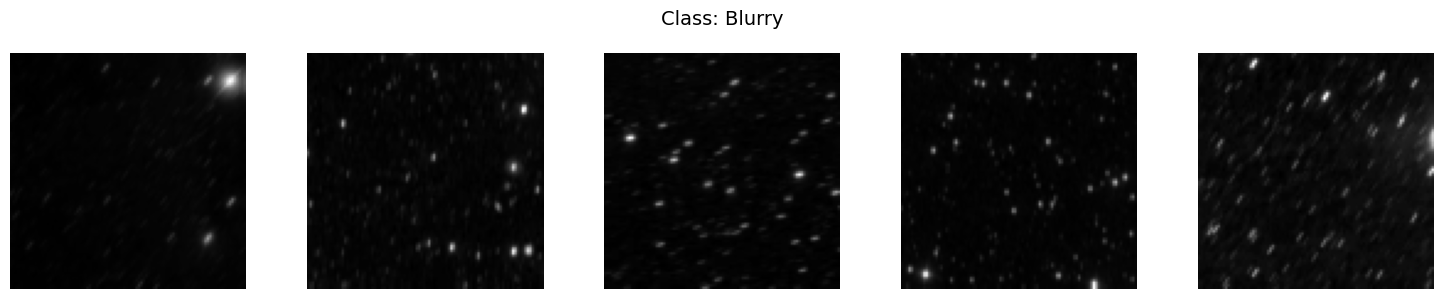

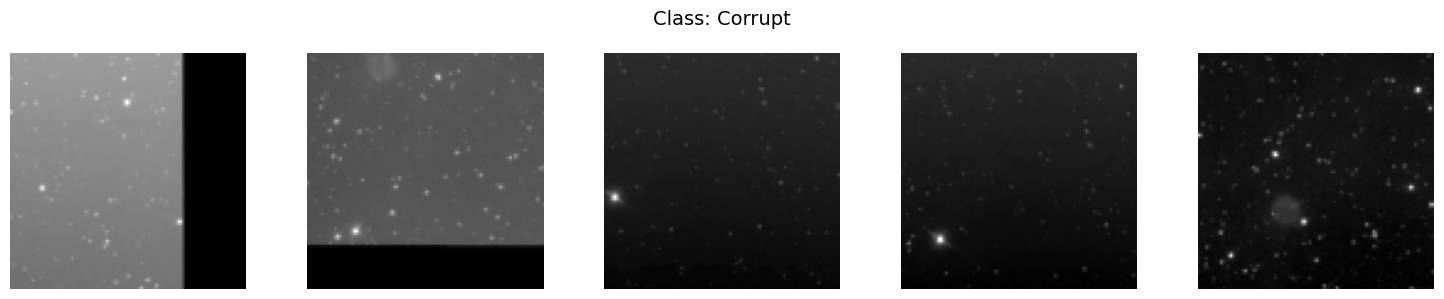

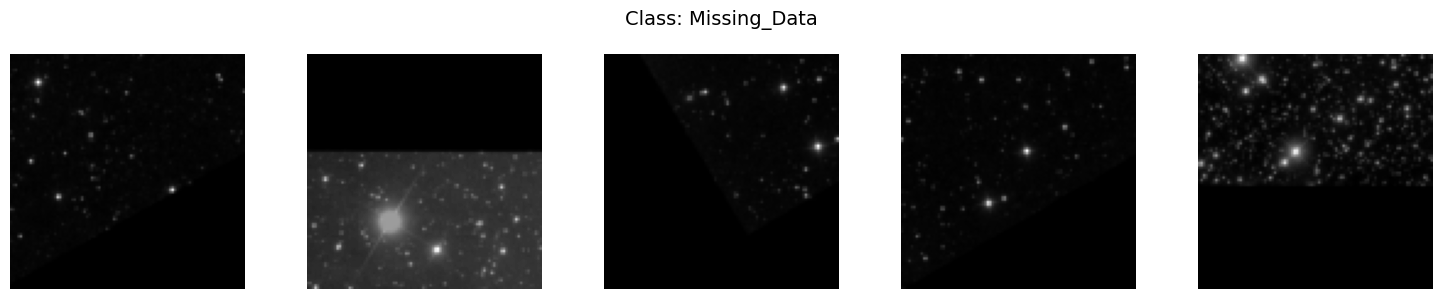

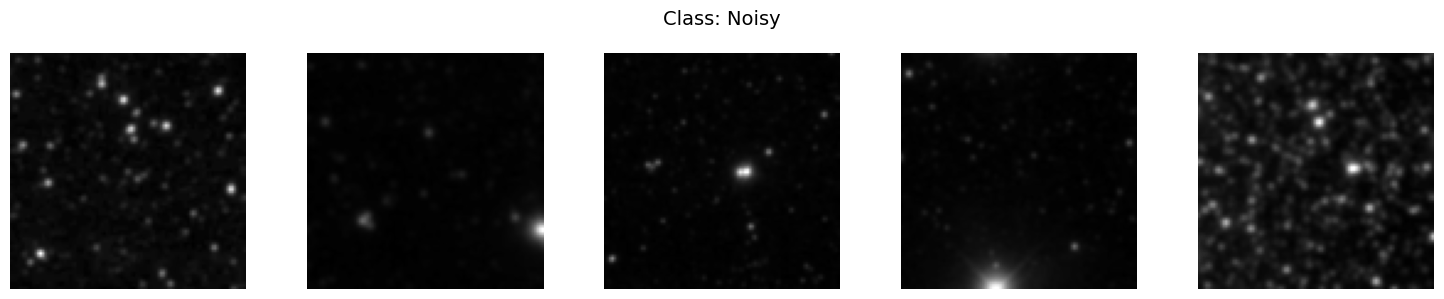

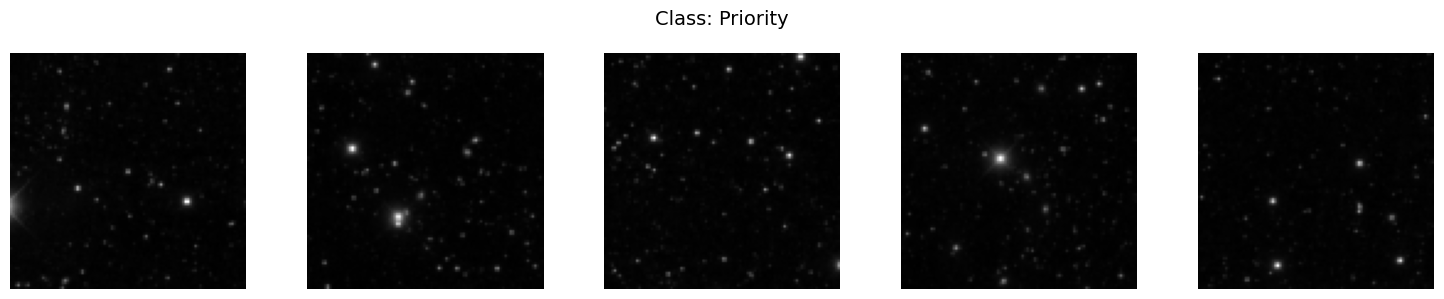

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Define class names (assuming labels are encoded from 0 to 4)
class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

# Display the first 5 images per class after preprocessing
for class_id in range(5):
    indices = np.where(train_labels == class_id)[0][:5]  # First 5 of the class
    images = train_images_pre[indices].reshape(-1, 96, 96)  # Reshape flattened back to 96x96

    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(f"Class: {class_names[class_id]}", fontsize=14)

    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

### Observation after Preprocessing
>After reviewing the pre-processed images, we observe that reducing the size from 512x512 to 96x96 has preserved much of the visual structure of the images. However, distinguishing between visually similar classes like Priority, Noisy, and Blurry can still be somewhat challenging at this resolution.
>This resolution strikes a balance between model efficiency and feature retention, which is crucial for deploying models in resource-constrained environments like CubeSats.

Now, let’s apply a machine learning method to classify these images based on their preprocessed features.

---

# ⚙️ ML Classification

### Train the XGBoost Model

In this section, we apply a classical machine learning algorithm — XGBoost (Extreme Gradient Boosting) — to classify the preprocessed satellite images.

> XGBoost is a high-performance, scalable implementation of gradient boosting that works exceptionally well on structured/tabular data. Compared to linear models like SGD, XGBoost can capture non-linear relationships in the data and usually provides higher accuracy.
Although it may require more computational resources than simple linear models, its ability to balance speed, accuracy, and robustness makes it an ideal choice for image classification in constrained environments such as CubeSats.

Let's now train the XGBoost model using the processed input data.


We now train the XGBoost model using manually tuned hyperparameters based on previous performance.

In [15]:
from xgboost import XGBClassifier
import time

best_model = XGBClassifier(
    n_estimators=250,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    gamma=0.1,
    objective='multi:softmax',
    num_class=5,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    verbosity=0,
    n_jobs=-1
)

print("Training tuned XGBoost...")
start_time = time.time()
best_model.fit(train_X, train_labels)
end_time = time.time()
print(f"Training done in {end_time - start_time:.2f} seconds.")


Training tuned XGBoost...
Training done in 928.63 seconds.


---

##  Saving the Trained Model
After training, we serialize and save the model using pickle.

In [16]:
import pickle

with open("ml_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Model saved as ml_model.pkl")


Model saved as ml_model.pkl


##  Evaluating Model Performance
We evaluate the model using accuracy, classification report, and confusion matrix.

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

preds = best_model.predict(val_X)
acc = accuracy_score(val_labels, preds)
report = classification_report(val_labels, preds, output_dict=True)

print(f"\nAccuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(val_labels, preds))


Accuracy: 0.8885

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       727
           1       1.00      1.00      1.00       222
           2       0.97      0.99      0.98       421
           3       0.83      0.82      0.82       721
           4       0.89      0.97      0.93      1146

    accuracy                           0.89      3237
   macro avg       0.91      0.90      0.91      3237
weighted avg       0.89      0.89      0.89      3237



### 🧾 Classification Report – Interpretation
The classification report confirms the strong performance of the XGBoost model across all five classes:

> **Class 0 – Blurry**

Precision: 87%

Recall: 74%

F1-score: 80%

**The model performs well on blurry images but sometimes confuses them with “Noisy” or “Priority” images, leading to a slightly reduced recall.**

> **Class 1 – Corrupt**

Precision / Recall / F1-score: 100%

**The model perfectly identifies corrupt images, showing excellent reliability for this class.**

> **Class 2 – Missing_Data**

Precision: 97%

Recall: 99%

F1-score: 98%

**Despite being a less frequent class, the model identifies it consistently and accurately.**

> **Class 3 – Noisy**

Precision: 83%

Recall: 82%

F1-score: 82%

**A solid result, though some noisy images are still confused with Priority or Blurry ones, likely due to visual similarities.**

> **Class 4 – Priority**

Precision: 89%

Recall: 97%

F1-score: 93%

**As the most critical class, Priority images are very well handled, with high precision and even higher recall.**

### 📌 Overall Metrics

Accuracy: 88.85%

Macro Average F1-score: 91% – balanced across all classes.

Weighted Average F1-score: 89% – shows excellent handling of class imbalance.

These results confirm that the tuned XGBoost model is both precise and robust. It performs especially well on the most important categories like Priority, while keeping false positives and misclassifications minimal.

### Plotting Per-Class Metrics
This section displays the per-class recall and F1-score using bar charts.

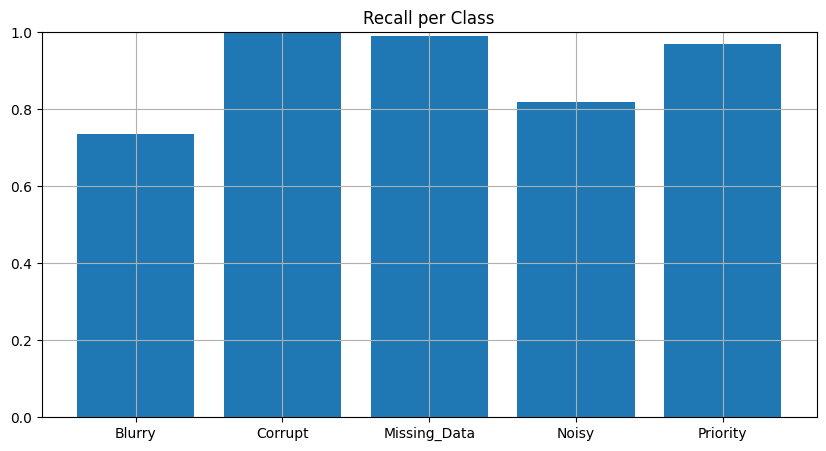

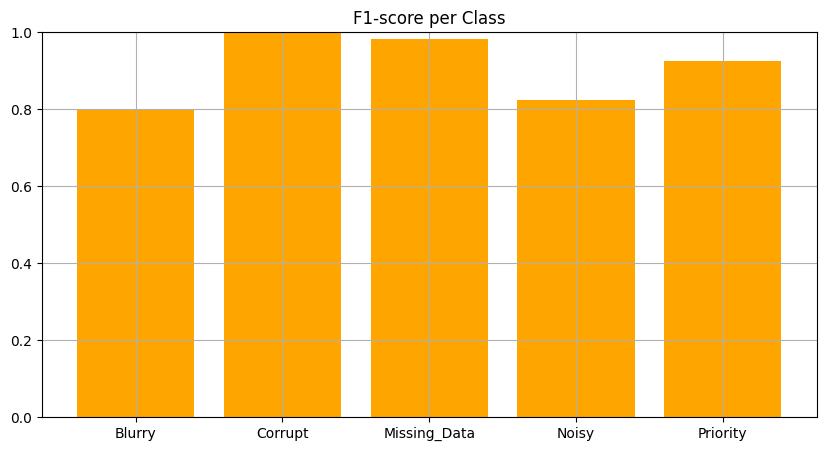

In [18]:
labels = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]
recall = [report[str(i)]['recall'] for i in range(5)]
f1 = [report[str(i)]['f1-score'] for i in range(5)]

plt.figure(figsize=(10, 5))
plt.bar(labels, recall)
plt.title("Recall per Class")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(labels, f1, color="orange")
plt.title("F1-score per Class")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


These charts confirm that the model performs very well on Priority, Corrupt, and Missing_Data classes.
Blurry and Noisy are slightly lower, which is expected due to their visual similarity.
Overall, the per-class metrics support the model's high accuracy and robustness.

## 🧩 Confusion Matrix
A confusion matrix for visual breakdown of class predictions.
> This matrix shows the detailed breakdown of the model's predictions vs. the actual labels.
It helps you understand where the model is making confusion errors.

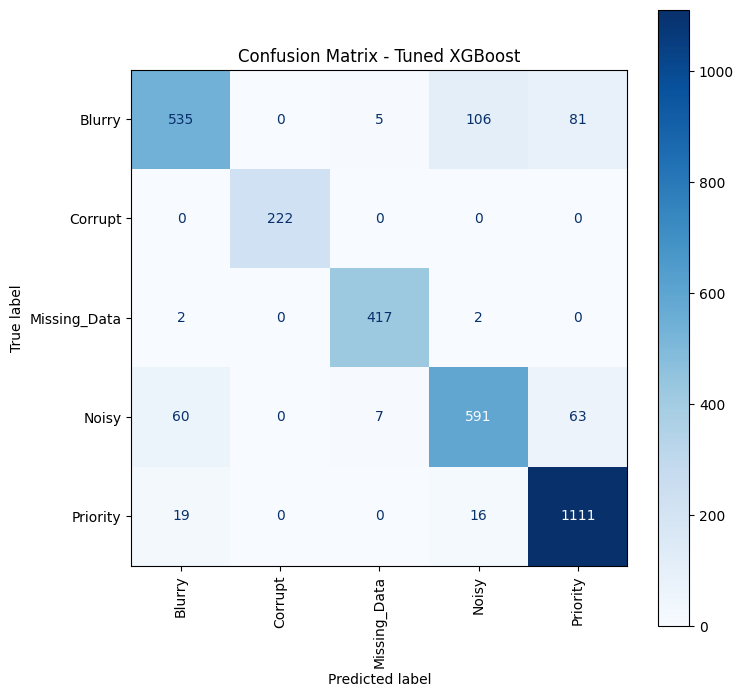

In [19]:
cm = confusion_matrix(val_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix - Tuned XGBoost")
plt.show()


##  Performance Analysis – Tuned XGBoost

The confusion matrix shows that the XGBoost model performs very well overall, especially for the Priority, Corrupt, and Missing_Data classes. 
Here's a breakdown:

>Priority (1,111/1,146): The model predicts this key class with very high accuracy (only 35 misclassified). This is crucial, since Priority images are the most important.

>Corrupt (222/222): Perfect classification. All corrupted images were identified correctly.

>Missing_Data (417/421): Almost all images with missing data were correctly detected. This proves strong performance even on degraded inputs.

>Noisy (591/721): Good results, but some confusion still exists with Blurry and Priority categories. This may stem from visual similarities between "noisy" and "blurry".

⚠️ Blurry (535/727): Performance is decent, but ~192 images were misclassified, mostly as Noisy or Priority. This indicates that the model sometimes struggles to distinguish unclear (blurry) images from recoverable ones (noisy/priority).

### Per-Class Metric Trends
This line chart highlights the precision, recall, and F1-score across each class. It offers a clearer comparison of how the model performs per class, making it easier to identify strengths and areas that might need refinement.

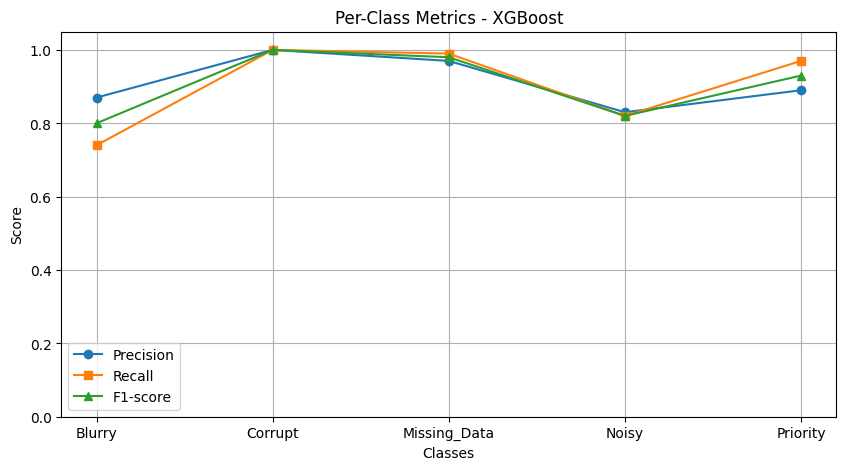

In [9]:
plt.figure(figsize=(10,5))
plt.plot(labels, precision, marker='o', label="Precision")
plt.plot(labels, recall, marker='s', label="Recall")
plt.plot(labels, f1, marker='^', label="F1-score")
plt.ylim(0, 1.05)
plt.title("Per-Class Metrics - XGBoost")
plt.xlabel("Classes")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

##  Conclusion:

The model reaches an accuracy of **~89%**, which is very solid for a 5-class classification task with overlapping visual features. Most misclassifications occur between blurry, noisy, and priority, which is expected due to their visual proximity.
However, the model excels at detecting Corrupt, Missing_Data, and Priority, making it a strong candidate for real-world deployment on resource-constrained CubeSat systems.

###  Clean Up Memory
Free up memory by deleting large arrays and invoking garbage collection.

In [22]:
import gc

del train_images, train_labels, val_images, val_labels, train_X, val_X
gc.collect()
print("Memory cleaned up.")

Memory cleaned up.


# EVALUATION

## Import Data

In [1]:
import numpy as np
# first let us load the testing data
test_images = np.load('data/test_images.npy')      # Load image test data
test_labels = np.load('data/test_labels.npy')      # Load label test data

### Import Evaluation function

In [2]:
from source.evaluate import evaluate_pipeline # A built-in function to evaluate a given ML pipeline by preprocessing, predicting, and calculating performance metrics.

## Evaluation

In [3]:
def preprocessing_fn_ML(X): # We apply the same pre-processing steps implemented in Notebook 3.
    from skimage.color import rgb2gray
    from skimage.transform import resize
    import numpy as np

    # Normalize
    X_pre = X.astype('float32') / 255.0
    
    # Grayscale
    X_pre = np.array([rgb2gray(image) for image in X_pre])
    
    # Resize to 96x96 because model was trained on 96x96
    X_pre = np.array([resize(image, (96, 96), anti_aliasing=True) for image in X_pre])
    
    # Flatten
    num_samples = X_pre.shape[0]
    X_pre = X_pre.reshape(num_samples, -1)  # should give shape (?, 9216)

    return X_pre

### Import model

In [4]:
import pickle
# Load the ml model from the 3rd notebook
with open('models/xgb_model.pkl', 'rb') as file:
    ml_model = pickle.load(file)

### ML Evaluation


### Evaluation Metrics ###

Evaluation Time:       36.72 seconds (The time it took for the pipeline to preprocess data and make predictions.)
Peak Memory Usage:     18618.04 MB (The maximum memory used during evaluation.)
Average CPU Usage:     99.35 % (The % shows how much of one CPU core was used during the evaluation.)
Algorithm code size:         4.74 MB (The size of the trained model and preprocessing function.)
Accuracy:              0.892 (The percentage of correctly classified samples.)
F1 Score:              0.889 (A balance of precision and recall, useful for imbalanced datasets.)

### Confusion Matrix ###



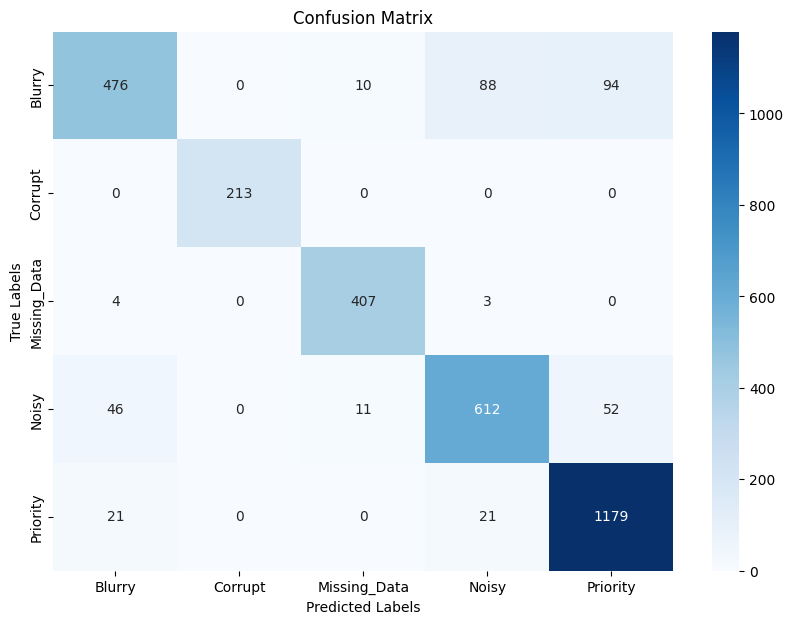

In [5]:
# Assuming you have:
# - A trained model named like 'lr_model'
# - Raw test data 'X_test_raw'
# - True labels 'y_test'
# - All pre-processing methods gathered in one function


# Evaluate the pipeline
metrics = evaluate_pipeline(ml_model, test_images, test_labels, preprocessing_fn_ML)

###  Evaluation Summary

The XGBoost model demonstrates **strong performance** on the test set with an **accuracy of 89.2%** and an **F1-score of 88.9%**, confirming its ability to generalize well on unseen data.  

Despite being slightly less accurate than the CNN model, it offers several key advantages:  
- **Low evaluation time** (36.72s),  
- **Reasonable memory usage** (18.6 GB peak),  
- **Compact code size** (4.74 MB), which is important for deployment on limited-resource platforms like CubeSats.  

Given its efficiency and high accuracy, this model represents a **robust and lightweight alternative to deep learning** approaches.


### Cleanup

In [6]:
import gc

# Remove the data from memory
del ml_model, test_images, test_labels

# Force garbage collection to free up memory
gc.collect()

# Clear the input/output cache
print("Data and models removed from memory.")

Data and models removed from memory.
